<a href="https://colab.research.google.com/github/reubenvas/Model-families/blob/main/all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Importing discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Importing the dataset


In [ ]:
# Importing from CSV file
df_training_data = pd.read_csv('training_data.csv', delimiter=",")
df_training_data['increase_stock'] = df_training_data['increase_stock'].replace(
    {'high_bike_demand': 1, 'low_bike_demand': 0})

In [ ]:
# Removing empty column snow
df_training_data = df_training_data.drop(['snow'], axis=1)

# Creating unified training and test set

In [ ]:
# Creating X - everything but column increase_stock
X = df_training_data.drop(['increase_stock'], axis=1)
y = df_training_data['increase_stock']

In [ ]:
# Splitting into 75% training and 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1477, stratify=y)

# Training the models

## Logistic regression

In [ ]:
def create_transformed_data(train_set, test_set):
    # Dividing day into three parts: morning, afternoon, and night. Creating new attribute is_morning, is_afternoon, and is_night
    train_set['is_morning'] = np.where((train_set['hour_of_day'] >= 8) & (train_set['hour_of_day'] < 15), 1, 0)
    train_set['is_afternoon'] = np.where((train_set['hour_of_day'] >= 15) & (train_set['hour_of_day'] < 20), 1, 0)
    train_set['is_night'] = np.where((train_set['hour_of_day'] >= 20) | (train_set['hour_of_day'] < 8), 1, 0)
    # Creating feature "rainy_day" which is 1 if precip >0 and 0 otherwise
    train_set['rainy_day'] = np.where(train_set['precip'] > 0, 1, 0)
    # Dropping feature precip
    train_set = train_set.drop(['precip'], axis=1)
    # Creating feature "snowy_day" which is 1 if snow >0 and 0 otherwise
    train_set['snowy_day'] = np.where(train_set['snowdepth'] > 0, 1, 0)
    # Dropping feature snowdepth
    train_set = train_set.drop(['snowdepth'], axis=1)
    # Dropping feature hour_of_day
    train_set = train_set.drop(['hour_of_day'], axis=1)

    # Dividing month into two parts: summer and winter. Creating new attribute is_summer
    train_set['is_summer'] = np.where((train_set['month'] >= 3) & (train_set['month'] <= 10), 1, 0)
    # Dropping feature month
    train_set = train_set.drop(['month'], axis=1)
    # Dropping summertime since it is basically "is_summer" but with a different name
    train_set = train_set.drop(['summertime'], axis=1)
    # Performing standardization per column using pandas functions and for loop on all atributes except "increase_stock"
    for column in train_set.columns:
        if column != 'increase_stock':
            train_set[column] = (train_set[column] - train_set[column].mean()) / train_set[column].std()
    return train_set, test_set

In [ ]:
X_train_logistic = X_train.copy()
y_train_logistic = y_train.copy()
X_train_logistic, y_train_logistic = create_transformed_data(X_train_logistic, y_train_logistic)

### Training

In [ ]:
import sklearn.linear_model as lm

# Doing grid seacrh to find best hyperparameters
# Defining parameters for grid search
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.arange(0.1, 1, 0.1),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10000],
    'class_weight': ['balanced', None]
}
# Creating logistic regression model
logistic_model = lm.LogisticRegression()
# Creating grid search
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
# Fitting grid search to training data
grid_search.fit(X_train_logistic, y_train_logistic)
# Fitting model to training data
logistic_model = grid_search.best_estimator_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\vblys\.conda\envs\AIIA\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
810 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vblys\.conda\envs\AIIA\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vblys\.conda\envs\AIIA\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\vblys\.conda\envs\AIIA\lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_solver(self.s

In [ ]:
print("Best parameters: ", grid_search.best_params_)
# Printing best cross-validation score
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters:  {'C': 0.30000000000000004, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.90


## LDA and QDA

### Transforming data

In [ ]:
X_train_LDA = X_train.copy()
y_train_LDA = y_train.copy()
X_train_LDA, y_train_LDA = create_transformed_data(X_train_LDA, y_train_LDA)

### Training

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Assuming X_train, y_train are already defined as our training data

# For LDA
lda = LinearDiscriminantAnalysis()
lda_params = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto'] + list(np.arange(0, 1, 0.1))
}
lda_grid = GridSearchCV(lda, lda_params, cv=5, scoring='accuracy')
lda_grid.fit(X_train_LDA, y_train_LDA)

# For QDA
qda = QuadraticDiscriminantAnalysis()
qda_params = {
    'reg_param': np.arange(0, 1, 0.1)
}
qda_grid = GridSearchCV(qda, qda_params, cv=5, scoring='accuracy', error_score='raise')
qda_grid.fit(X_train_LDA, y_train_LDA)

# store the best models
lda_best_model = lda_grid.best_estimator_
qda_best_model = qda_grid.best_estimator_

C:\Users\vblys\.conda\envs\AIIA\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
61 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vblys\.conda\envs\AIIA\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vblys\.conda\envs\AIIA\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\vblys\.conda\envs\AIIA\lib\site-packages\sklearn\discriminant_analysis.py", line 637, in fit
    self._solve_eigen(
  File "C:\User

In [ ]:
# Best parameters and scores
lda_best_params = lda_grid.best_params_
lda_best_score = lda_grid.best_score_

qda_best_params = qda_grid.best_params_
qda_best_score = qda_grid.best_score_

# Print
print("LDA best parameters: ", lda_best_params)
print("LDA best score: ", lda_best_score)
print("QDA best parameters: ", qda_best_params)
print("QDA best score: ", qda_best_score)


LDA best parameters:  {'shrinkage': 0.7000000000000001, 'solver': 'lsqr'}
LDA best score:  0.8783333333333333
QDA best parameters:  {'reg_param': 0.8}
QDA best score:  0.8775000000000001


## K-NN

### Transforming data

In [ ]:
def transform_Knn(train_set, test_set):
    # Doing min/max scaling and standardization
    for column in train_set.columns:
        if column != 'increase_stock':
            train_set[column] = (train_set[column] - train_set[column].mean()) / train_set[column].std()
            # Min/max scaling
            train_set[column] = (train_set[column] - train_set[column].min()) / (train_set[column].max() - train_set[column].min())
    return train_set, test_set

X_train_Knn = X_train.copy()
y_train_Knn = y_train.copy()
X_train_Knn, y_train_Knn = transform_Knn(X_train_Knn, y_train_Knn)

### Training

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 100)}

# Create a base model
knn = KNeighborsClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_Knn, y_train_Knn)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Get the best parameters
best_params = grid_search.best_params_

# Create a new model with the best parameters
best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])

# Fit the new model to the data
best_knn.fit(X_train_Knn, y_train_Knn)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Best Parameters:  {'n_neighbors': 14}


KNeighborsClassifier(n_neighbors=14)

## Random forest / Trees

### Training

#### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

basic_dt_clf = DecisionTreeClassifier(random_state=1477)
# parametrs for grid search
param_grid = {
    'max_depth': range(1, 7, 1),
    'min_samples_split': range(2, 25, 2),
    'min_samples_leaf': range(1, 11, 1)
}

In [ ]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=1477)
gs_dt_clf = GridSearchCV(estimator=basic_dt_clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
gs_dt_clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1477, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1477), n_jobs=-1,
             param_grid={'max_depth': range(1, 7),
                         'min_samples_leaf': range(1, 11),
                         'min_samples_split': range(2, 25, 2)},
             scoring='accuracy')

In [ ]:
# Print the best parameters
print("Best Parameters: ", gs_dt_clf.best_params_)

Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Decision tree with hierarchical shrinkage

In [ ]:
from imodels import HSTreeClassifierCV, get_clean_dataset
# Converting X_train to numpy array X_train_HS
X_train_HS = X_train.to_numpy()
# Converting y_train to numpy array y_train_HS
y_train_HS = y_train.to_numpy()
# Storing feature names in list feature_names_HS
feature_names_HS = list(X_train.columns)

In [ ]:
HS_DT = HSTreeClassifierCV(max_leaf_nodes=5)
HS_DT.fit(X_train_HS, y_train_HS)

#### Random forest

In [ ]:
param_grid = {
    'n_estimators': range(50, 651, 200),
    'max_depth': range(5, 8, 1),
    'min_samples_split': range(2, 21, 4),
    'min_samples_leaf': range(1, 6, 1),
}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

basic_rf_clf = RandomForestClassifier(random_state=2036, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1477)
gs_rf_clf = GridSearchCV(estimator=basic_rf_clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
gs_rf_clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1477, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=2036),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 8),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 21, 4),
                         'n_estimators': range(50, 651, 200)},
             scoring='accuracy')

In [ ]:
# Print the best parameters
print("Best Parameters: ", gs_rf_clf.best_params_)

Best Parameters:  {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 250}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### HS Random forest

In [ ]:
from imodels import HSTreeClassifier
from sklearn.ensemble import RandomForestClassifier
ensemble = RandomForestClassifier()
HSRF_model = HSTreeClassifierCV(estimator_=basic_rf_clf)
HSRF_model.fit(X_train_HS, y_train_HS)

### Creating model for

# Creating naive model always guessing 0

In [ ]:
# Creating naive model always guessing 0
def naive_model(train_set):
    # Returning vector of zeros with length of train_set
    return np.zeros(len(train_set))

# Testing the models

Doing naive predictions on test set

In [ ]:
x_test_naive = X_test.copy()
y_test_naive = y_test.copy()
y_pred_naive = naive_model(x_test_naive)

Doing predictions on test set with logistic reg

In [ ]:
# Logistic regression
X_test_logistic = X_test.copy()
y_test_logistic = y_test.copy()
X_test_logistic, y_test_logistic = create_transformed_data(X_test_logistic, y_test_logistic)
y_pred_logistic = logistic_model.predict(X_test_logistic)

Doing predictions on test set with LDA

In [ ]:
# LDA
X_test_LDA = X_test.copy()
y_test_LDA = y_test.copy()
X_test_LDA, y_test_LDA = create_transformed_data(X_test_LDA, y_test_LDA)
y_pred_LDA = lda_best_model.predict(X_test_LDA)

Doing predictions on test set with QDA

In [ ]:
x_test_QDA = X_test.copy()
y_test_QDA = y_test.copy()
x_test_QDA, y_test_QDA = create_transformed_data(x_test_QDA, y_test_QDA)
y_pred_QDA = qda_best_model.predict(x_test_QDA)

Doing predictions on test set with K-NN

In [ ]:
# K-NN
X_test_Knn = X_test.copy()
y_test_Knn = y_test.copy()
X_test_Knn, y_test_Knn = transform_Knn(X_test_Knn, y_test_Knn)
y_pred_Knn = best_knn.predict(X_test_Knn)

Doing prediction on test set with Decision tree

In [ ]:
y_pred_dt = gs_dt_clf.predict(X_test)

Doing prediction on test set with Random forest

In [ ]:
y_pred_rf = gs_rf_clf.predict(X_test)

Doing prediction on test set with hierarchical shrinkage

In [ ]:
y_pred_HS = HS_DT.predict(X_test.to_numpy())

Doing prediction on test set with hierarchical shrinkage and random forest

In [ ]:
y_pred_HS_RF = HSRF_model.predict(X_test.to_numpy())

## Compraing predictions between the models

In [ ]:
# Printing classification records for all models
print("Logistic regression")
print(classification_report(y_test_logistic, y_pred_logistic, digits=5))
print("LDA")
print(classification_report(y_test_LDA, y_pred_LDA, digits=5))
print("QDA")
print(classification_report(y_test_QDA, y_pred_QDA, digits=5))
print("K-NN")
print(classification_report(y_test_Knn, y_pred_Knn, digits=5))
print("Decision tree")
print(classification_report(y_test, y_pred_dt, digits=5))
print("Random forest")
print(classification_report(y_test, y_pred_rf, digits=5))
print("Naive model")
print(classification_report(y_test_naive, y_pred_naive, digits=5))
print("Hierarchical shrinkage")
print(classification_report(y_test, y_pred_HS, digits=5))
print("Hierarchical shrinkage with random forest")
print(classification_report(y_test, y_pred_HS_RF, digits=5))

Logistic regression
              precision    recall  f1-score   support

           0    0.90855   0.93902   0.92354       328
           1    0.67213   0.56944   0.61654        72

    accuracy                        0.87250       400
   macro avg    0.79034   0.75423   0.77004       400
weighted avg    0.86600   0.87250   0.86828       400

LDA
              precision    recall  f1-score   support

           0    0.91843   0.92683   0.92261       328
           1    0.65217   0.62500   0.63830        72

    accuracy                        0.87250       400
   macro avg    0.78530   0.77591   0.78045       400
weighted avg    0.87050   0.87250   0.87143       400

QDA
              precision    recall  f1-score   support

           0    0.93354   0.89939   0.91615       328
           1    0.60714   0.70833   0.65385        72

    accuracy                        0.86500       400
   macro avg    0.77034   0.80386   0.78500       400
weighted avg    0.87479   0.86500   0.86893   

C:\Users\vblys\anaconda3\envs\AIIA\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vblys\anaconda3\envs\AIIA\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vblys\anaconda3\envs\AIIA\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Plotting all models on same ROC curve
# Logistic regression
logistic_roc_auc = roc_auc_score(y_test_logistic, y_pred_logistic)
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test_logistic, logistic_model.predict_proba(X_test_logistic)[:, 1])
# LDA
LDA_roc_auc = roc_auc_score(y_test_LDA, y_pred_LDA)
fpr_LDA, tpr_LDA, thresholds_LDA = roc_curve(y_test_LDA, lda_best_model.predict_proba(X_test_LDA)[:, 1])
# QDA
QDA_roc_auc = roc_auc_score(y_test_QDA, y_pred_QDA)
fpr_QDA, tpr_QDA, thresholds_QDA = roc_curve(y_test_QDA, qda_best_model.predict_proba(x_test_QDA)[:, 1])
# K-NN
Knn_roc_auc = roc_auc_score(y_test_Knn, y_pred_Knn)
fpr_Knn, tpr_Knn, thresholds_Knn = roc_curve(y_test_Knn, best_knn.predict_proba(X_test_Knn)[:, 1])
# Decision tree
dt_roc_auc = roc_auc_score(y_test, y_pred_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, gs_dt_clf.predict_proba(X_test)[:, 1])
# Random forest
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, gs_rf_clf.predict_proba(X_test)[:, 1])
# Hierarchical shrinkage
HS_roc_auc = roc_auc_score(y_test, y_pred_HS)
fpr_HS, tpr_HS, thresholds_HS = roc_curve(y_test, HS_DT.predict_proba(X_test.to_numpy())[:, 1])
# Hierarchical shrinkage with random forest
HS_RF_roc_auc = roc_auc_score(y_test, y_pred_HS_RF)
fpr_HS_RF, tpr_HS_RF, thresholds_HS_RF = roc_curve(y_test, HSRF_model.predict_proba(X_test.to_numpy())[:, 1])

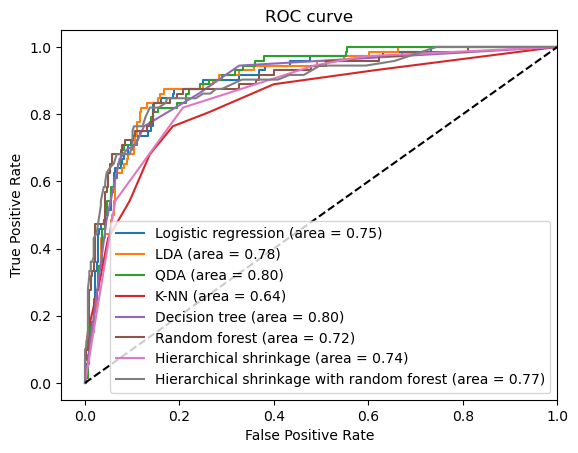

In [ ]:
# Plotting ROC curve
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, label='Logistic regression (area = %0.2f)' % logistic_roc_auc)
plt.plot(fpr_LDA, tpr_LDA, label='LDA (area = %0.2f)' % LDA_roc_auc)
plt.plot(fpr_QDA, tpr_QDA, label='QDA (area = %0.2f)' % QDA_roc_auc)
plt.plot(fpr_Knn, tpr_Knn, label='K-NN (area = %0.2f)' % Knn_roc_auc)
plt.plot(fpr_dt, tpr_dt, label='Decision tree (area = %0.2f)' % dt_roc_auc)
plt.plot(fpr_rf, tpr_rf, label='Random forest (area = %0.2f)' % rf_roc_auc)
# HS_roc_auc
plt.plot(fpr_HS, tpr_HS, label='Hierarchical shrinkage (area = %0.2f)' % HS_roc_auc)
# HS_RF_roc_auc
plt.plot(fpr_HS_RF, tpr_HS_RF, label='Hierarchical shrinkage with random forest (area = %0.2f)' % HS_RF_roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
# Including legend
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()


In [ ]:
# Comparing performance between test set and training sets

In [ ]:
# getting the accuracy score for each model on the training set
logistic_train_score = accuracy_score(y_train_logistic, logistic_model.predict(X_train_logistic))
LDA_train_score = accuracy_score(y_train_LDA, lda_best_model.predict(X_train_LDA))
QDA_train_score = accuracy_score(y_train_LDA, qda_best_model.predict(X_train_LDA))
Knn_train_score = accuracy_score(y_train_Knn, best_knn.predict(X_train_Knn))
dt_train_score = accuracy_score(y_train, gs_dt_clf.predict(X_train))
rf_train_score = accuracy_score(y_train, gs_rf_clf.predict(X_train))
naive_train_score = accuracy_score(y_train, naive_model(X_train))

# printing it out
print("Logistic regression training accuracy: ", logistic_train_score)
print("LDA training accuracy: ", LDA_train_score)
print("QDA training accuracy: ", QDA_train_score)
print("K-NN training accuracy: ", Knn_train_score)
print("Decision tree training accuracy: ", dt_train_score)
print("Random forest training accuracy: ", rf_train_score)
print("Naive model training accuracy: ", naive_train_score)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Logistic regression training accuracy:  0.8991666666666667
LDA training accuracy:  0.8791666666666667
QDA training accuracy:  0.8825
K-NN training accuracy:  0.8708333333333333
Decision tree training accuracy:  0.9066666666666666
Random forest training accuracy:  0.9216666666666666
Naive model training accuracy:  0.82
